In [ ]:
#!pip install pycodestyle_magic flake8
%load_ext pycodestyle_magic
%flake8_on

In [1]:
import bempp.api
import bemppUQ
import numpy as np
from bemppUQ.config import config
from bemppUQ.operators.maxwell import assemble_operators, evaluate_far_field
from bemppUQ.utils.mie import bhmie
from decimal import Decimal
from matplotlib import pyplot as plt

bempp.api.global_parameters.assembly.potential_operator_assembly_type = "dense"

In [2]:
k_ext, k_int = config["k_ext"], config["k_int"]
lambda_par, freq = config["lambda"], config["frequency"]
polarization = config["polarization"]
direction = config["direction"]

eps_rel = config["eps_rel"]
mu_rel = config["mu_rel"]
print("The exterior wavenumber is: {0}".format(k_ext))
print("The interior wavenumber is: {0}".format(k_int))

print("----")
print("The exterior wavelenght is: {0}".format(lambda_par))
print("The exterior frequency is: {:.2E}".format(Decimal(freq)))

The exterior wavenumber is: 5.0
The interior wavenumber is: 6.892024376045111
----
The exterior wavelenght is: 1.2566370614359172
The exterior frequency is: 2.39E+8


In [3]:
precision = 10

h = 2.0 * np.pi / (precision * config["k_int"])

grid = bempp.api.shapes.sphere(h=h)
k_int, k_ext = config["k_int"], config["k_ext"]
print(grid.leaf_view.entity_count(1))
n = k_int / k_ext
refIndex = n
numAngles = 901
s1, s2, qext, qsca, qback, gsca = bhmie(k_ext, k_int / k_ext, numAngles)
transmission_operators = assemble_operators(grid, config)
far_field, solution = evaluate_far_field(transmission_operators, config)

6012
iteration - 1 || residual - 0.23457917154621108 0.4917747974395752
iteration - 2 || residual - 0.07654056445112542 0.13457131385803223
iteration - 3 || residual - 0.03673135262721691 0.12680530548095703
iteration - 4 || residual - 0.015788337174277148 0.137359619140625
iteration - 5 || residual - 0.007160998376647395 0.13260650634765625
iteration - 6 || residual - 0.003754396725627815 0.14987635612487793
iteration - 7 || residual - 0.001815865681671384 0.15045738220214844
iteration - 8 || residual - 0.0007463602546814936 0.15126776695251465
iteration - 9 || residual - 0.00035610298111561807 0.13118934631347656
iteration - 10 || residual - 0.00019576098222638644 0.12838053703308105
iteration - 11 || residual - 0.00011772794376584658 0.14342069625854492
iteration - 12 || residual - 7.713738374332899e-05 0.13930845260620117
iteration - 13 || residual - 4.64431516330603e-05 0.13865113258361816
iteration - 14 || residual - 2.89763363632567e-05 0.13383746147155762
iteration - 15 || resi

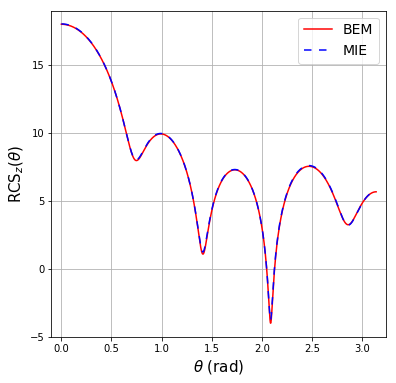

In [9]:
angles = config['angles']
k_ext = config['k_ext']

fig, ax  = plt.subplots(1,1, figsize=(6,6))
plt.rcParams['figure.figsize'] = (15, 4) # Increase the figure size in the notebook

A22 = far_field[2,:]
uh = 10 * np.log10(4 * np.pi * np.abs(A22[:1801]))
u =  10 * np.log10(4 * np.pi * np.abs(s1 / (-1j * k_ext) ))
# -1j * kExt is to make agree with eqn 3.21 p70 tBohren and Huffman

ax.plot(angles[:1801], uh, '-r', label='BEM')
ax.plot(angles[:1801], u, 'b', label='MIE', linestyle=(0, (5, 5)))

ax.set_xlabel(r"$\theta$ (rad)", fontsize=15)
ax.set_ylabel(r"$\mathrm{RCS}_z(\theta)$", fontsize=15)

ymin, ymax = uh.min() - 1, uh.max() + 1
ax.legend(prop={'size': 14})
ax.grid()
plt.xlim(-0.1, np.pi + 0.1)
plt.ylim(ymin, ymax)
plt.savefig("plots/RCSSphere.pdf")
plt.show()

In [8]:
precision_list = [1, 2, 5, 10, 20, 30, 40, 50, 60]

for precision in precision_list:
    h = 2 * np.pi / (precision * k_ext)
    print("Starting run for precision: ", precision)

    grid = bempp.api.shapes.sphere(h=h)
    N = 2 * grid.leaf_view.entity_count(1)
    print("Ndof: ", N)
    bempp.api.global_parameters.hmat.eps = 1e-4
    transmission_operators = assemble_operators(grid, config)
    far_field, solution = evaluate_far_field(transmission_operators, config)

    A22 = -1j * k_ext * far_field[2, :]
    name = "results/" + "precision" + str(precision)

    my_dict = {
        "A22": A22,
        "h": h,
        "N": N,
    }

    np.save(name + ".npy", my_dict)

Starting run for precision:  1
Ndof:  144
iteration - 1 || residual - 0.316644872294 0.013995885848999023
iteration - 2 || residual - 0.143872340969 0.005075693130493164
iteration - 3 || residual - 0.0809891247399 0.009541034698486328
iteration - 4 || residual - 0.0541260758726 0.011266708374023438
iteration - 5 || residual - 0.0349621772467 0.008616209030151367
iteration - 6 || residual - 0.0206817512232 0.005164146423339844
iteration - 7 || residual - 0.0129304743124 0.0070078372955322266
iteration - 8 || residual - 0.00750212308905 0.004738569259643555
iteration - 9 || residual - 0.00463504238765 0.004789113998413086
iteration - 10 || residual - 0.00297619188799 0.005022287368774414
iteration - 11 || residual - 0.00179942673382 0.019185543060302734
iteration - 12 || residual - 0.00100238373101 0.005161285400390625
iteration - 13 || residual - 0.000623106319334 0.00880122184753418
iteration - 14 || residual - 0.000335116567318 0.004224300384521484
iteration - 15 || residual - 0.00020

iteration - 9 || residual - 0.000335623142929 1.1921145915985107
iteration - 10 || residual - 0.000190714802379 1.1220800876617432
iteration - 11 || residual - 0.000139134099912 1.0943307876586914
iteration - 12 || residual - 0.000108833435384 1.0793170928955078
iteration - 13 || residual - 7.19606837906e-05 1.1030008792877197
iteration - 14 || residual - 4.29782188151e-05 1.0878572463989258
iteration - 15 || residual - 3.16693652314e-05 1.0738723278045654
iteration - 16 || residual - 2.24500397464e-05 1.134073257446289
iteration - 17 || residual - 1.40080554048e-05 1.3198182582855225
iteration - 18 || residual - 1.04841362442e-05 1.418245792388916
iteration - 19 || residual - 7.72835221212e-06 0.0264434814453125
Starting run for precision:  50
Ndof:  144438
iteration - 1 || residual - 0.23335254782 3.646245002746582
iteration - 2 || residual - 0.0760095994415 1.7956576347351074
iteration - 3 || residual - 0.0364276742708 1.790388584136963
iteration - 4 || residual - 0.0154987439975 2.